In [12]:
import PinkBlack.io
from PinkBlack.trainer import Trainer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


import os, glob
import numpy as np
from sklearn.model_selection import train_test_split

from dataset.kernel_image_pair import KernelImagePair, default_augmentations, default_transforms
from network.sftmd import SFTMD, Predictor, Corrector

In [143]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [13]:
import numpy as np
import math
from torchvision.utils import make_grid
def tensor2img(tensor, out_type=np.uint8, min_max=(0, 1)):
    '''
    Converts a torch Tensor into an image Numpy array
    Input: 4D(B,(3/1),H,W), 3D(C,H,W), or 2D(H,W), any range, RGB channel order
    Output: 3D(H,W,C) or 2D(H,W), [0,255], np.uint8 (default)
    '''
    tensor = tensor.squeeze().float().cpu().clamp_(*min_max)  # clamp
    tensor = (tensor - min_max[0]) / (min_max[1] - min_max[0])  # to range [0,1]
    n_dim = tensor.dim()
    if n_dim == 4:
        n_img = len(tensor)
        img_np = make_grid(tensor, padding=0, nrow=1, normalize=False).numpy()
        img_np = np.transpose(img_np[[2, 1, 0], :, :], (1, 2, 0))  # HWC, BGR
    elif n_dim == 3:
        img_np = tensor.numpy()
        img_np = np.transpose(img_np[[2, 1, 0], :, :], (1, 2, 0))  # HWC, BGR
    elif n_dim == 2:
        img_np = tensor.numpy()
    else:
        raise TypeError(
            'Only support 4D, 3D and 2D tensor. But received with dimension: {:d}'.format(n_dim))
    if out_type == np.uint8:
        img_np = (img_np * 255.0).round()
        # Important. Unlike matlab, numpy.unit8() WILL NOT round by default.
    return img_np.astype(out_type)

In [160]:
def show_results(sr, ds):
    sr = tensor2img(sr)
    lr = Image.fromarray(tensor2img(ds['LR']))
    hr = Image.fromarray(tensor2img(ds['HR']))
#     display(lr)
#     display(lr.resize((lr.size[0]*scale, lr.size[1]*scale), Image.BICUBIC))
#     display(Image.fromarray(sr))
#     display(hr)
    fig = plt.figure(figsize=[6.4*6, 4.8*4])

    fig.add_subplot(3,12,26)
    plt.imshow(lr)
    fig.add_subplot(142)
    plt.imshow(lr.resize((lr.size[0]*scale, lr.size[1]*scale), Image.BICUBIC))
    fig.add_subplot(143)
    plt.imshow(sr)
    fig.add_subplot(144)
    plt.imshow(hr)

In [2]:
class SRDataset(KernelImagePair):
    def __init__(self, sftmd, predictor, **kwargs):
        super(SRDataset, self).__init__(**kwargs)

    def __getitem__(self, idx):
        bd = super().__getitem__(idx)
        return bd

    def __len__(self):
        return super().__len__()

In [31]:
train_imgs = glob.glob("../data/DIV2K/DIV2K_train_HR/**/*.png", recursive=True)
test_imgs = glob.glob("../data/DIV2K/DIV2K_valid_HR/**/*.png", recursive=True)
train_kernel = "kernels/train/kernel_scale3_iso_dim10.pth"
test_kernel = "kernels/test/kernel_scale3_iso_dim10.pth"
ckpt = "ckpt/sftmd/191006_0_sftmd.pth"
scale=3
batch_size=1

test_imgs = glob.glob("../data/testing_datasets/Set5/**/*.png", recursive=True)
test_imgs

['../data/testing_datasets/Set5/butterfly.png',
 '../data/testing_datasets/Set5/baby.png',
 '../data/testing_datasets/Set5/woman.png',
 '../data/testing_datasets/Set5/head.png',
 '../data/testing_datasets/Set5/bird.png']

In [32]:
test_dataset = KernelImagePair(imgs=test_imgs, 
                            kernel_pickle=test_kernel, scale=scale, 
                            augmentations=default_augmentations, transforms=default_transforms, 
                            seed=0, train=False)

In [33]:
dl = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

In [24]:
net = SFTMD(scale=3).cuda()
net.load_state_dict(torch.load(ckpt))
net.eval()
""

''

In [142]:
import json
predictor = Predictor().cuda()
predictor.load_state_dict(torch.load("ckpt/sftmd/191006_2_predictor.pth"))
predictor.eval()
json.load(open("ckpt/sftmd/191006_2_predictor.pth.config"))

{'max_train_metric': -0.0032915559349955188,
 'max_val_metric': -0.0024580464399020585,
 'max_test_metric': -0.00044676820762106216,
 'logdir': './pinkblack_autolog/',
 'timestamp': '20191007_003303',
 'clip_gradient_norm': 3.0,
 'is_data_dict': True,
 'step': 44000,
 'train_loss': 0.0032915559349955188,
 'train_metric': -0.0032915559349955188,
 'val_loss': 0.0024580464399020585,
 'val_metric': -0.0024580464399020585,
 'test_loss': 0.0013220787543104962,
 'test_metric': -0.0013220787543104962,
 'set5_loss': 0.001347823904749627,
 'set5_metric': -0.001347823904749627,
 'max_set5_metric': 0.0}

In [192]:
it = iter(dl)

In [193]:
ds = next(it)
for k, v in ds.items():
    if torch.is_tensor(v):
        ds[k] = v.cuda()

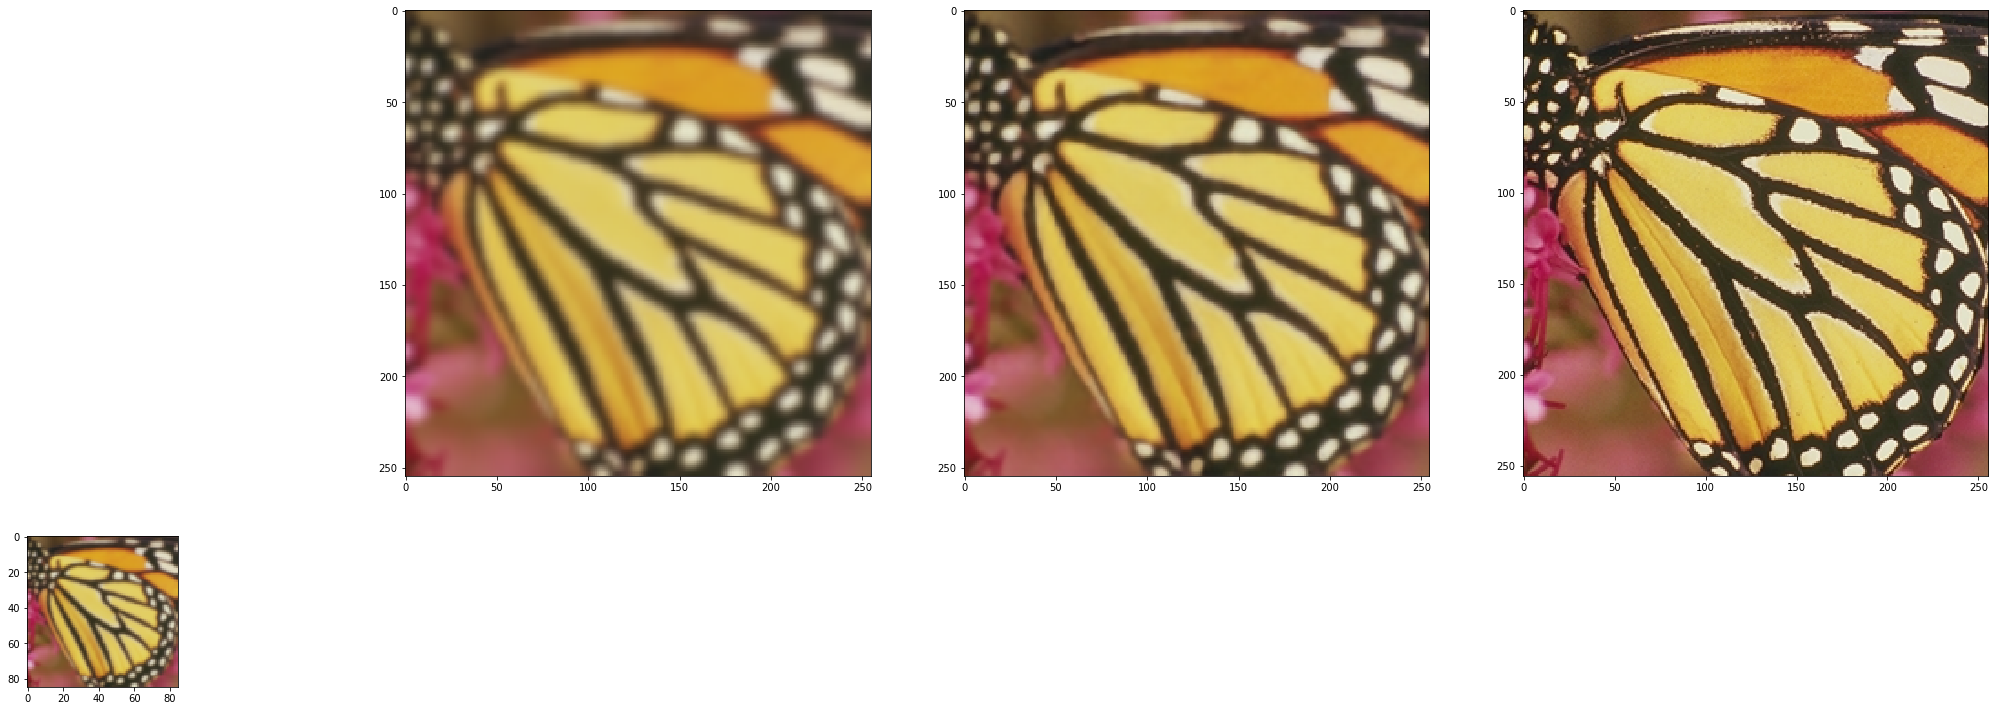

In [194]:
with torch.no_grad():
    sr = net(ds)
show_results(sr, ds)

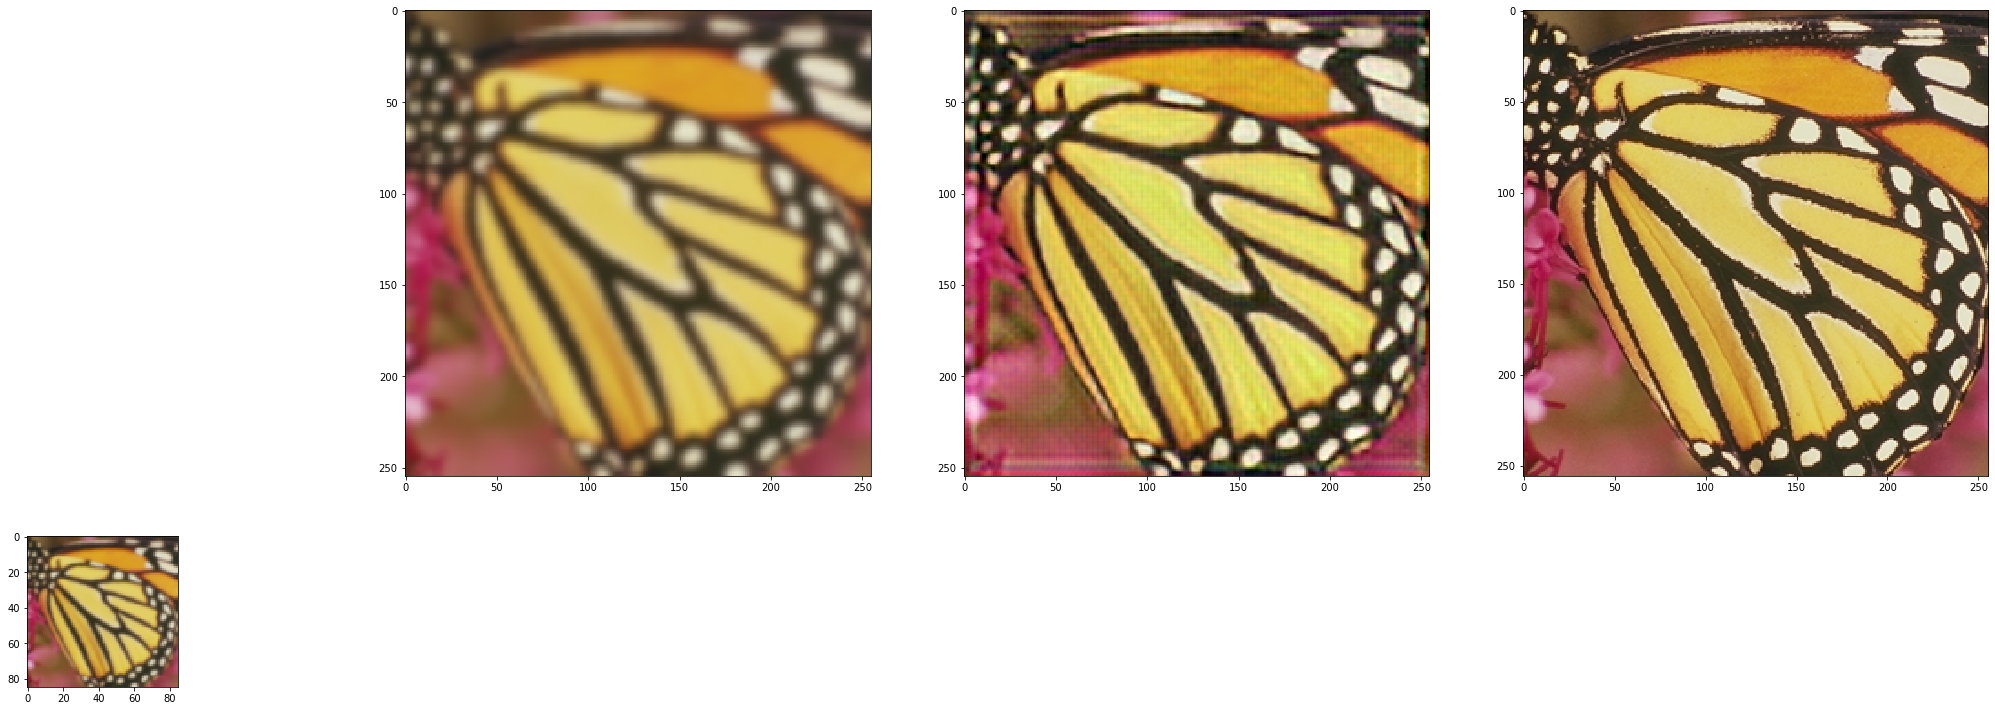

In [195]:
with torch.no_grad():
    k_reduced = predictor(ds)
ds['k_save'] = ds['k_reduced']
ds['k_reduced'] = k_reduced 
k_np = k_reduced[0].cpu().numpy()
k_save = ds['k_save'][0].cpu().numpy()
with torch.no_grad():
    sr = net(ds)
show_results(sr, ds)

In [196]:
k_np

array([-0.10613064,  0.0142858 , -0.02737907, -0.00969018, -0.00965684,
       -0.00935374, -0.00775238, -0.00923917, -0.00870334, -0.0084226 ],
      dtype=float32)

In [197]:
invo = test_dataset.pca.inverse_transform(k_save).reshape(21,21)

In [198]:
inve = test_dataset.pca.inverse_transform(k_np).reshape(21,21)

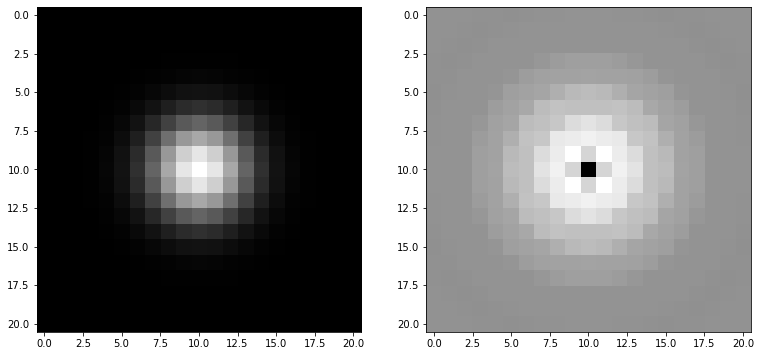

In [199]:
plt.figure(figsize=(12.8, 9.6))
fig = plt.subplot(121)
fig.imshow(invo/invo.sum(), cmap="gray")
fig = plt.subplot(122)
fig.imshow(inve/inve.sum(), cmap="gray")
